In [1]:
file_cutoff = 55
plot_cutoff = 5.5
exclusion = 3

In [2]:
from numpy.core.fromnumeric import amin
import pandas as pd
from read_input import read_pdbs
import itertools
from itertools import product, combinations


native_pdb, fibril_pdb = read_pdbs()

# Make a dictionary from the pdb of resnum:resid from the pdb structure
pdb_resids = native_pdb.residues.resids.tolist()
amino_dict = dict(zip(pdb_resids,(list(native_pdb.residues.resnames))))

# Same dictionary but also with number and names
pdb_resid_name = native_pdb.residues.resnames + '_' + native_pdb.residues.resids.astype(str)
amino_dict_num = dict(zip(pdb_resids,pdb_resid_name))
#print(amino_dict)
#print(amino_dict_num)

# Create the DataFrame of the pairs list
pairs_list = pd.read_csv(f'GRETA/output_TTR/pairs_list_c{file_cutoff}_ex{exclusion}_noN.txt', sep='\\s+')

pairs_list.insert(1, 'ai_resnumber', '')
pairs_list.insert(1, 'ai_resname', '')
pairs_list.insert(4, 'aj_resnumber', '')
pairs_list.insert(4, 'aj_resname', '')

# Separation of the atomtype and the aminoacid number. 
# The atomtype column will be replaced avoiding to create a column and delete this one.
pairs_list[['ai_resname', 'ai_resnumber']] = pairs_list.ai.str.split("_", expand = True)
pairs_list[['aj_resname', 'aj_resnumber']] = pairs_list.aj.str.split("_", expand = True)
# Replacing the atomtype values with aminoacid number as int
pairs_list['ai_resname'] = pairs_list['ai_resnumber'].astype(int)
pairs_list['aj_resname'] = pairs_list['aj_resnumber'].astype(int)
# Conversion from str to int
pairs_list['ai_resnumber'] = pairs_list['ai_resnumber'].astype(int)
pairs_list['aj_resnumber'] = pairs_list['aj_resnumber'].astype(int)
# Replacing the aminoacid number with the aminoacid name
pairs_list['ai_resname'] = pairs_list.ai_resname.map(amino_dict)
pairs_list['aj_resname'] = pairs_list.aj_resname.map(amino_dict)

print(pairs_list)#.to_string())


       ai ai_resname  ai_resnumber     aj aj_resname  aj_resnumber  type  \
0    CA_1        TYR             1   CA_1        TYR             1     1   
1    CA_1        TYR             1   CA_2        THR             2     1   
2    CA_1        TYR             1   CB_1        TYR             1     1   
3    CA_1        TYR             1  CB_11        SER            11     1   
4    CA_1        TYR             1   CB_2        THR             2     1   
..    ...        ...           ...    ...        ...           ...   ...   
875   O_7        LEU             7    O_7        LEU             7     1   
876   O_7        LEU             7    O_8        SER             8     1   
877   O_8        SER             8    O_8        SER             8     1   
878   O_8        SER             8    O_9        PRO             9     1   
879   O_9        PRO             9    O_9        PRO             9     1   

           c6       c12     sigma  epsilon  
0    0.005918  0.000031  0.416116    0.285

In [3]:
contacts_histogram = {}
sigma_histogram = {}
for an in pdb_resids:
    # pdb_resids is the aminocid numbers
    # Selection of the rows contaning the aminoacid number of interest.
    # Note the | and not the &
    is_an = (pairs_list['ai_resnumber'] == an) | (pairs_list['aj_resnumber'] == an)

    # Filtering a dataframe containing only the aminoacid selected.
    pairs_an = pairs_list[is_an]

    print(pairs_an.to_string())

    print(f'\nTotal amount of contacts made by {amino_dict_num.get(an)}:', len(pairs_an))
    pairs_an.loc[pairs_an['ai_resnumber'] == an, 'an_with_who'] = pairs_an['aj_resname'] + '_' + pairs_an['aj_resnumber'].astype(str)
    pairs_an.loc[pairs_an['ai_resnumber'] != an, 'an_with_who'] = pairs_an['ai_resname'] + '_' + pairs_an['ai_resnumber'].astype(str)
    #print(pairs_an.to_string())
    
    # Create Pandas Series with contact counts for every aminoacid in an selection:
    # an_with_who count of the unique values in column "an_with_who" in pairs_an dataframe
    an_with_who = pairs_an.an_with_who.value_counts()
    print(f'\nList of contacts based on aminoacid:\n{an_with_who.to_string()}')

    # Change "an_with_who" in a dictionary to put in a matrix
    contacts_histogram['{0}'.format(an)] = an_with_who.to_dict()
    print(f'\nAnd the consequent nested dictionary:\n{contacts_histogram}\n')


    # Matrix Sigma creation
    set_an_with_who = set(pairs_an["an_with_who"])

    sigma_dict = {}
    for s in set_an_with_who:
        sigma_dict[s] = 0.00000
        is_s = pairs_an["an_with_who"] == s
        sigmas_an = pairs_an[is_s]
        mean_sigma = sigmas_an['sigma'].mean()
        print(f'Average sigma of {amino_dict_num.get(an)} with {s}', '%.5f'%mean_sigma)
        sigma_dict[s] = '%.5f'%mean_sigma

    sigma_histogram['{0}'.format(an)] = sigma_dict
    #print(f'Nested dictionary of the sigmas:\n{sigma_histogram}\n\n')


#print(f'Complete matrix of all contacts:\n{contacts_histogram}\n')
#print(f'Complete matrix of the sigma distances:{sigma_histogram}')


         ai ai_resname  ai_resnumber      aj aj_resname  aj_resnumber  type        c6           c12     sigma  epsilon
0      CA_1        TYR             1    CA_1        TYR             1     1  0.005918  3.072438e-05  0.416116    0.285
1      CA_1        TYR             1    CA_2        THR             2     1  0.014677  1.889696e-04  0.484125    0.285
2      CA_1        TYR             1    CB_1        TYR             1     1  0.006818  4.077226e-05  0.426044    0.285
3      CA_1        TYR             1   CB_11        SER            11     1  0.005964  3.120146e-05  0.416651    0.285
4      CA_1        TYR             1    CB_2        THR             2     1  0.014353  1.807103e-04  0.482325    0.285
5      CA_1        TYR             1   CD1_1        TYR             1     1  0.003386  1.005491e-05  0.379131    0.285
6      CA_1        TYR             1   CD2_1        TYR             1     1  0.012484  1.367166e-04  0.471241    0.285
7      CA_1        TYR             1  CD2_10    

In [4]:
# Contact dataframe preparation

histo_df = pd.DataFrame(contacts_histogram)
histo_df[''] = histo_df.index.astype(str)
histo_df[''] = histo_df[''].str.split('_').str[1].astype(int)
histo_df.sort_values(by = [''], inplace = True)
histo_df.drop(columns='', inplace=True)
histo_df = histo_df.fillna(0)
histo_df.columns = list(amino_dict_num.values())
print(histo_df.to_string())



        TYR_1  THR_2  ILE_3  ALA_4  ALA_5  LEU_6  LEU_7  SER_8  PRO_9  TYR_10  SER_11
TYR_1    52.0   23.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    48.0    60.0
THR_2    23.0   26.0   15.0    0.0    0.0    0.0    0.0    0.0   20.0    26.0    18.0
ILE_3     1.0   15.0   32.0   19.0    1.0    1.0    0.0   13.0   11.0    20.0     0.0
ALA_4     0.0    0.0   19.0   15.0   13.0    0.0   17.0    1.0   11.0     0.0     0.0
ALA_5     0.0    0.0    1.0   13.0   15.0   24.0   12.0    0.0    0.0     0.0     0.0
LEU_6     0.0    0.0    1.0    0.0   24.0   35.0   45.0    5.0    0.0     0.0     4.0
LEU_7     0.0    0.0    0.0   17.0   12.0   45.0   32.0   16.0    5.0     0.0     9.0
SER_8     0.0    0.0   13.0    1.0    0.0    5.0   16.0   21.0   20.0     5.0    35.0
PRO_9     0.0   20.0   11.0   11.0    0.0    0.0    5.0   20.0   28.0    20.0     0.0
TYR_10   48.0   26.0   20.0    0.0    0.0    0.0    0.0    5.0   20.0    63.0    16.0
SER_11   60.0   18.0    0.0    0.0    0.0    4.0    9.

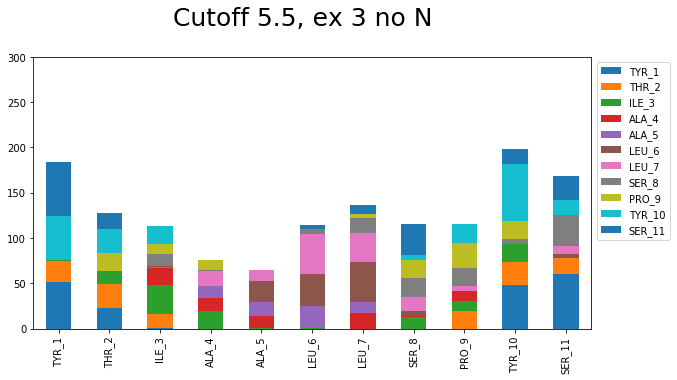

In [16]:
# Sum of the contacts for every aminoacid
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

histo_df.plot(kind = "bar", stacked = True, figsize = (10,5))
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
plt.suptitle(f'Cutoff {plot_cutoff}, ex {exclusion} no N', fontsize = 25, y = 1.02)
plt.ylim(0, 300)
plt.show()


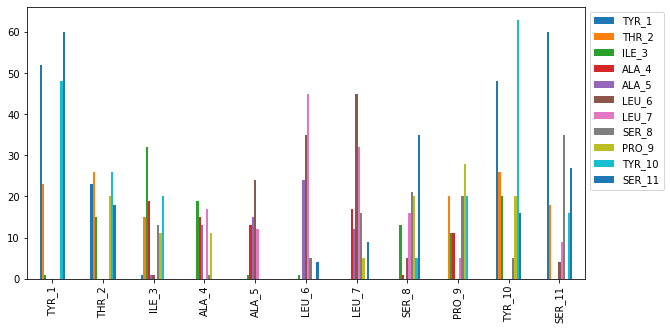

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

histo_df.plot(kind = "bar", stacked = False, figsize = (10,5))
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
plt.show()

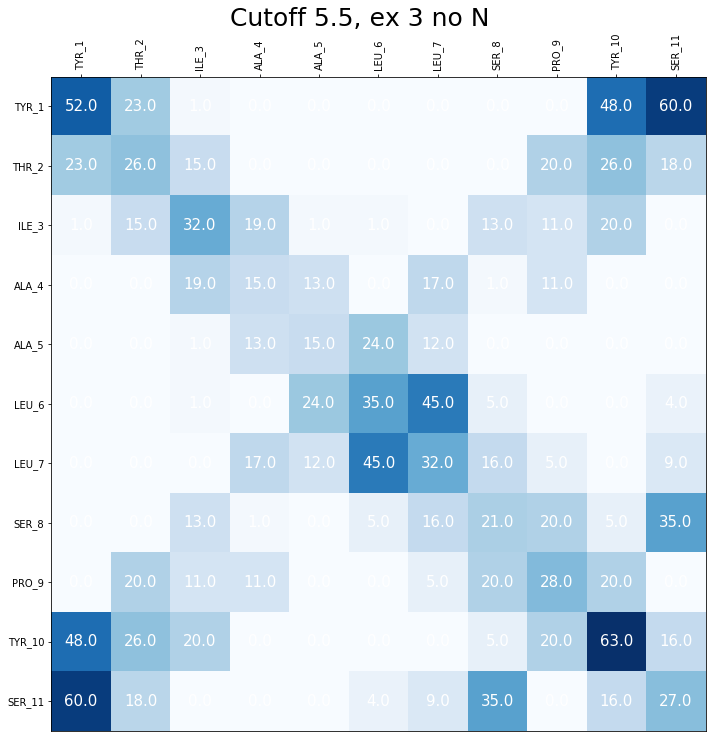

In [7]:
import numpy as np

matrix_df = histo_df.to_numpy()
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(matrix_df, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax.set_xticks(np.arange(len(histo_df.columns)))
ax.set_yticks(np.arange(len(histo_df.index)))
# Naming all the axis values
ax.set_xticklabels(list(histo_df.columns))
ax.set_yticklabels(list(histo_df.index))
# Rotate x labels
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(histo_df.index)):
    for j in range(len(histo_df.columns)):
        text = ax.text(j,i, matrix_df[i,j], ha='center', va='center', color='w', fontsize = 15)
plt.suptitle(f'Cutoff {plot_cutoff}, ex {exclusion} no N', fontsize = 25, y = 1.02)
fig.tight_layout()

In [8]:
# Making a normalized dataframe and matrix
histo_df_norm = histo_df.div(histo_df.max().max())
pd.options.display.float_format = '{:.2f}'.format
print(histo_df_norm.to_string())

        TYR_1  THR_2  ILE_3  ALA_4  ALA_5  LEU_6  LEU_7  SER_8  PRO_9  TYR_10  SER_11
TYR_1    0.83   0.37   0.02   0.00   0.00   0.00   0.00   0.00   0.00    0.76    0.95
THR_2    0.37   0.41   0.24   0.00   0.00   0.00   0.00   0.00   0.32    0.41    0.29
ILE_3    0.02   0.24   0.51   0.30   0.02   0.02   0.00   0.21   0.17    0.32    0.00
ALA_4    0.00   0.00   0.30   0.24   0.21   0.00   0.27   0.02   0.17    0.00    0.00
ALA_5    0.00   0.00   0.02   0.21   0.24   0.38   0.19   0.00   0.00    0.00    0.00
LEU_6    0.00   0.00   0.02   0.00   0.38   0.56   0.71   0.08   0.00    0.00    0.06
LEU_7    0.00   0.00   0.00   0.27   0.19   0.71   0.51   0.25   0.08    0.00    0.14
SER_8    0.00   0.00   0.21   0.02   0.00   0.08   0.25   0.33   0.32    0.08    0.56
PRO_9    0.00   0.32   0.17   0.17   0.00   0.00   0.08   0.32   0.44    0.32    0.00
TYR_10   0.76   0.41   0.32   0.00   0.00   0.00   0.00   0.08   0.32    1.00    0.25
SER_11   0.95   0.29   0.00   0.00   0.00   0.06   0.1

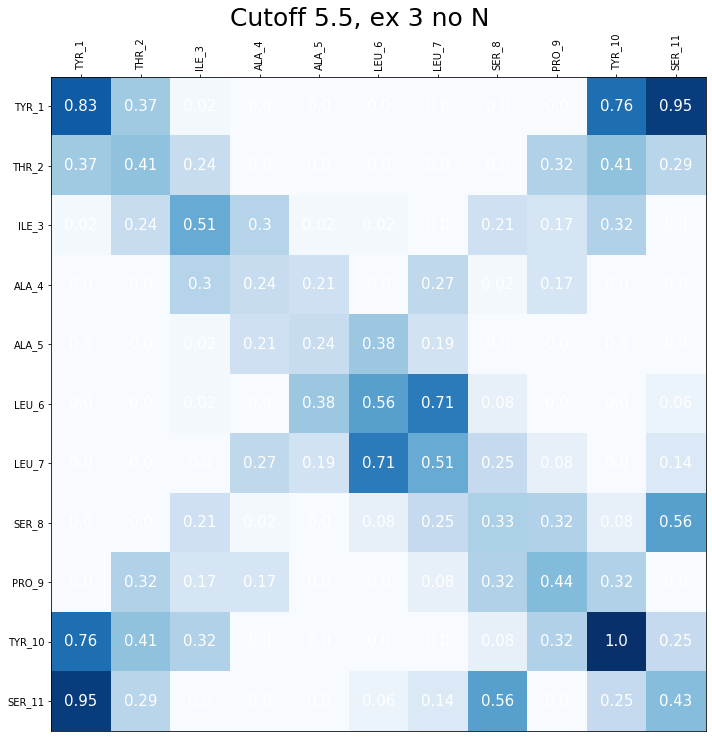

In [9]:
matrix_norm_df = histo_df_norm.to_numpy()
matrix_norm_df = matrix_norm_df.round(decimals = 2)

# plot creation
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(matrix_norm_df, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax.set_xticks(np.arange(len(histo_df_norm.columns)))
ax.set_yticks(np.arange(len(histo_df_norm.index)))
# Naming all the axis values
ax.set_xticklabels(list(histo_df_norm.columns))
ax.set_yticklabels(list(histo_df_norm.index))
# Rotate x labels
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(histo_df_norm.index)):
    for j in range(len(histo_df_norm.columns)):
        text = ax.text(j,i, matrix_norm_df[i,j], ha='center', va='center', color='w', fontsize = 15)
plt.suptitle(f'Cutoff {plot_cutoff}, ex {exclusion} no N', fontsize = 25, y = 1.02)
fig.tight_layout()

In [10]:
# Sigmas dataframe preparation

pd.options.display.float_format = '{:,.5f}'.format
histo_sigma = pd.DataFrame(sigma_histogram)
histo_sigma = histo_sigma.apply(pd.to_numeric)
histo_sigma[''] = histo_sigma.index.astype(str)
histo_sigma[''] = histo_sigma[''].str.split('_').str[1].astype(int)
histo_sigma.sort_values(by = [''], inplace = True)
histo_sigma.drop(columns='', inplace=True)
#histo_sigma = histo_sigma.fillna(0)
histo_sigma.columns = list(amino_dict_num.values())
print(histo_sigma.to_string())


         TYR_1   THR_2   ILE_3   ALA_4   ALA_5   LEU_6   LEU_7   SER_8   PRO_9  TYR_10  SER_11
TYR_1  0.39609 0.38083 0.45118     nan     nan     nan     nan     nan     nan 0.40782 0.37672
THR_2  0.38083 0.40163 0.41250     nan     nan     nan     nan     nan 0.41496 0.38818 0.40904
ILE_3  0.45118 0.41250 0.41624 0.37236 0.44228 0.45621     nan 0.39143 0.40439 0.38870     nan
ALA_4      nan     nan 0.37236 0.38578 0.40622     nan 0.42061 0.46416 0.40331     nan     nan
ALA_5      nan     nan 0.44228 0.40622 0.38525 0.39710 0.43143     nan     nan     nan     nan
LEU_6      nan     nan 0.45621     nan 0.39710 0.39512 0.40584 0.45569     nan     nan 0.40789
LEU_7      nan     nan     nan 0.42061 0.43143 0.40584 0.39084 0.42851 0.45951     nan 0.43796
SER_8      nan     nan 0.39143 0.46416     nan 0.45569 0.42851 0.40247 0.41788 0.42036 0.39778
PRO_9      nan 0.41496 0.40439 0.40331     nan     nan 0.45951 0.41788 0.39592 0.40934     nan
TYR_10 0.40782 0.38818 0.38870     nan     nan    

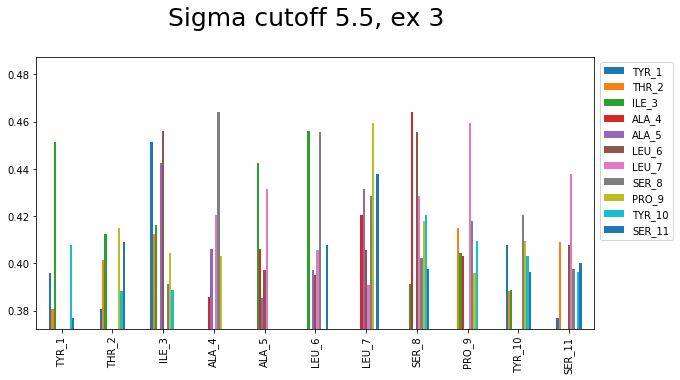

0.37235999999999997


In [11]:
histo_sigma.plot(kind = "bar", stacked = False, figsize = (10,5))
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
plt.ylim(bottom=(histo_sigma.min()).min())
plt.suptitle(f'Sigma cutoff {plot_cutoff}, ex {exclusion}', fontsize = 25, y = 1.02)
plt.show()
print((histo_sigma.min()).min())

In [12]:
# Distance dataframe preparation

histo_distance = histo_sigma.apply(lambda a: a*(2**(1/6)))
histo_distance[''] = histo_distance.index.astype(str)
histo_distance[''] = histo_distance[''].str.split('_').str[1].astype(int)
histo_distance.sort_values(by = [''], inplace = True)
histo_distance.drop(columns='', inplace=True)
#histo_distance = histo_distance.fillna(0)
histo_distance.columns = list(amino_dict_num.values())
print(histo_distance.to_string())

         TYR_1   THR_2   ILE_3   ALA_4   ALA_5   LEU_6   LEU_7   SER_8   PRO_9  TYR_10  SER_11
TYR_1  0.44460 0.42747 0.50643     nan     nan     nan     nan     nan     nan 0.45776 0.42285
THR_2  0.42747 0.45081 0.46302     nan     nan     nan     nan     nan 0.46578 0.43572 0.45913
ILE_3  0.50643 0.46302 0.46721 0.41796 0.49644 0.51208     nan 0.43937 0.45391 0.43630     nan
ALA_4      nan     nan 0.41796 0.43302 0.45597     nan 0.47212 0.52100 0.45270     nan     nan
ALA_5      nan     nan 0.49644 0.45597 0.43243 0.44573 0.48426     nan     nan     nan     nan
LEU_6      nan     nan 0.51208     nan 0.44573 0.44351 0.45554 0.51149     nan     nan 0.45784
LEU_7      nan     nan     nan 0.47212 0.48426 0.45554 0.43870 0.48099 0.51578     nan 0.49159
SER_8      nan     nan 0.43937 0.52100     nan 0.51149 0.48099 0.45176 0.46905 0.47184 0.44649
PRO_9      nan 0.46578 0.45391 0.45270     nan     nan 0.51578 0.46905 0.44441 0.45947     nan
TYR_10 0.45776 0.43572 0.43630     nan     nan    

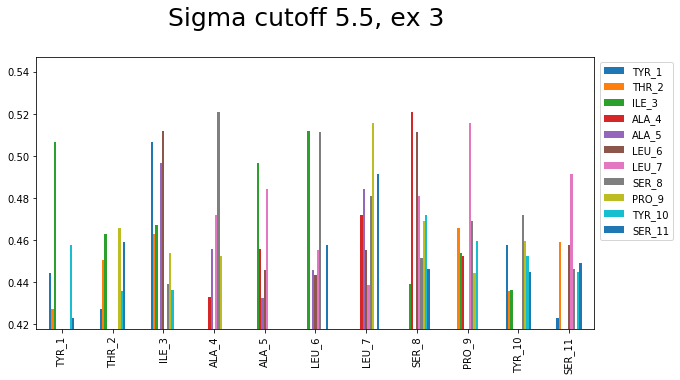

0.4179599683084781


In [13]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

histo_distance.plot(kind = "bar", stacked = False, figsize = (10,5))
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
plt.ylim(bottom=(histo_distance.min()).min())
plt.suptitle(f'Sigma cutoff {plot_cutoff}, ex {exclusion}', fontsize = 25, y = 1.02)
plt.show()
print((histo_distance.min()).min())